<center>
КОНКУРСНАЯ ЗАДАЧА TINKOFF DATA SCIENCE CHALLENGE:
<center>   
Необходимо предсказать, откроет ли клиент кредитный счет  или нет.

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns

import chardet
from bs4 import UnicodeDammit

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import random

from tqdm.auto import tqdm
import re

In [96]:
RND_STATE = 777
random.seed(RND_STATE)

# Считывание данных в формате .csv в DataFrame

In [3]:
data_encodings = []

with open("Data\credit_train.csv", 'rb') as f:
    rawdata = b''.join([f.readline() for _ in range(1000)])
    data_encodings.append(chardet.detect(rawdata)['encoding'])
    data_encodings.append(UnicodeDammit(rawdata).original_encoding)
       
print(f"Кодировка исходного файла: {data_encodings}")

Кодировка исходного файла: ['KOI8-R', 'koi8-r']


Однако, кодировка KOI8-R не подходит для корректного открытия файла, поэтому было решено проверить наиболее распространенные кодировки для файлов, содержащих кириллицу.

In [4]:
data_encodings.extend(['utf-16','CP866', 'Windows-1251', 'utf-8', 'cp1251'])

In [5]:
file_encoding = ''
for encoding in data_encodings:
    try:
        with pd.read_csv("Data\credit_train.csv", encoding=encoding, sep=";", index_col='client_id', iterator=True) as reader:
            print('--------------------------------')
            print(f'Кодировка: {encoding}')
            print(reader.get_chunk(5))
            print('--------------------------------\n')
        if input("Если кодировка верна, введи 'верно' >>>>  ") == 'верно':
            file_encoding = encoding
            break
    except UnicodeDecodeError:
        print(f'Кодировка: {encoding} не подходит!')

--------------------------------
Кодировка: KOI8-R
          gender   age marital_status job_position credit_sum  credit_month  \
client_id                                                                     
1              M   NaN            NaN          UMN   59998,00            10   
2              F   NaN            MAR          UMN   10889,00             6   
3              M  32.0            MAR          SPC   10728,00            12   
4              F  27.0            NaN          SPC   12009,09            12   
5              M  45.0            NaN          SPC        NaN            10   

           tariff_id score_shk education        living_region  monthly_income  \
client_id                                                                       
1                1.6       NaN       GRD   йпюямндюпяйхи йпюи         30000.0   
2                1.1       NaN       NaN               лняйбю             NaN   
3                1.1       NaN       NaN      нак яюпюрнбяйюъ          

In [6]:
init_data = pd.read_csv("Data\credit_train.csv", encoding=file_encoding, sep=";")
init_data.head(5)

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,"59998,00",10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,"10889,00",6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,"10728,00",12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,NaN,SPC,"12009,09",12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,NaN,SPC,NaN,10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


In [7]:
print(f'Число наблюдений - {init_data.shape[0]}')
print(f'Число фичей (переменных) - {init_data.shape[1]}')

Число наблюдений - 170746
Число фичей (переменных) - 15


# Предварительная подготовка данных

**Список переменных:**

* `client_id` - Идентификационный номер клиента

* `gender` - Пол

* `age` - Возраст

* `marital_status` - Семейный статус

* `job_position` - Сфера занятости

* `credit_sum` - Сумма кредита

* `credit_month` - Срок кредитования

* `tariff_id` - Идентификационный номер тарифа

* `score_shk` - Внутренняя скоринговая оценка

* `education` - Образование

* `living_region` - Регион проживания

* `monthly_income` - Месячный заработок

* `credit_count` - Количество кредитов у клиента

* `overdue_credit_count` - Количество просроченных кредитов у клиента

* `open_account_flg` - Факт открытия кредитного счета в данном банке (целевая переменная)

## Удаление очевидных бесполезных переменных

В данном случае имеются ввиду переменные, у которых количество категорий совпадает с количеством наблюдений, или, наоборот, переменные с одним уникальным значением.

In [8]:
init_data.nunique()

client_id               170746
gender                       2
age                         54
marital_status               5
job_position                18
credit_sum               42769
credit_month                31
tariff_id                   32
score_shk                16279
education                    5
living_region              301
monthly_income            1591
credit_count                21
overdue_credit_count         4
open_account_flg             2
dtype: int64

Откинем столбец `client_id` поскольку он совпадает с номером наблюдения и не несет никакой предсказательной способности.

In [9]:
init_data.drop('client_id', inplace=True, axis=1)

In [10]:
init_data.head(5)

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,NaN,NaN,UMN,"59998,00",10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,F,NaN,MAR,UMN,"10889,00",6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,M,32.0,MAR,SPC,"10728,00",12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,F,27.0,NaN,SPC,"12009,09",12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,M,45.0,NaN,SPC,NaN,10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


## Преобразование типов данных

В данном разделе подразумевается преобразование типов данных к корректным, например, `credit_sum` в датасете имеет тип `object`, чего не должно быть. Также, часто переменные-флаги, такие как "наличие оттока", "наличие дефолта" и т.п. записываются как целочисленные значения.

In [11]:
init_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170743 non-null  float64
 2   marital_status        170743 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170744 non-null  object 
 5   credit_month          170746 non-null  int64  
 6   tariff_id             170746 non-null  float64
 7   score_shk             170739 non-null  object 
 8   education             170741 non-null  object 
 9   living_region         170554 non-null  object 
 10  monthly_income        170741 non-null  float64
 11  credit_count          161516 non-null  float64
 12  overdue_credit_count  161516 non-null  float64
 13  open_account_flg      170746 non-null  int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 18.

In [12]:
for column in ['score_shk', 'credit_sum']:
    init_data[column] = init_data[column].str.replace(',', '.').astype('float')

In [13]:
for column in ['tariff_id', 'open_account_flg']:
    init_data[column] = init_data[column].astype('object')

In [14]:
init_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170743 non-null  float64
 2   marital_status        170743 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170744 non-null  float64
 5   credit_month          170746 non-null  int64  
 6   tariff_id             170746 non-null  object 
 7   score_shk             170739 non-null  float64
 8   education             170741 non-null  object 
 9   living_region         170554 non-null  object 
 10  monthly_income        170741 non-null  float64
 11  credit_count          161516 non-null  float64
 12  overdue_credit_count  161516 non-null  float64
 13  open_account_flg      170746 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 18.

In [15]:
init_data.head(5)

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,NaN,NaN,UMN,59998.00,10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,F,NaN,MAR,UMN,10889.00,6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,M,32.0,MAR,SPC,10728.00,12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,F,27.0,NaN,SPC,12009.09,12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,M,45.0,NaN,SPC,NaN,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


## Нормализация строковых значений

В данный этап обработки данных входит удаление лишних символов, приведение строк к одному и тому же регистру.
В исследуемом датасете необходимо обработать колонку `living_region`, поскольку уже по нескольким первым записям видно, что вид регионов не стандартизован.

In [16]:
init_data['living_region'].nunique()

301

In [17]:
pd.options.display.max_rows = 310

In [18]:
init_data['living_region'].value_counts(dropna=False).sort_index()

74                                              1
98                                              1
АДЫГЕЯ РЕСП                                     9
АЛТАЙСКИЙ                                       2
АЛТАЙСКИЙ КРАЙ                                  8
АМУРСКАЯ ОБЛ                                   12
АМУРСКАЯ ОБЛАСТЬ                               20
АО НЕНЕЦКИЙ                                    20
АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю      559
АО ЯМАЛО-НЕНЕЦКИЙ                             141
АОБЛ ЕВРЕЙСКАЯ                                  4
АРХАНГЕЛЬСКАЯ                                   1
АРХАНГЕЛЬСКАЯ ОБЛ                              18
АРХАНГЕЛЬСКАЯ ОБЛАСТЬ                           9
АСТРАХАНСКАЯ                                   25
АСТРАХАНСКАЯ ОБЛ                               31
АСТРАХАНСКАЯ ОБЛАСТЬ                          143
БАШКОРТОСТАН                                   26
БАШКОРТОСТАН РЕСП                             133
БЕЛГОРОДСКАЯ ОБЛ                               29


In [19]:
region_unique = init_data['living_region'].unique()
regions = pd.Series(data=region_unique, index=region_unique, name='regions')

In [20]:
region_stopwords = ['ОБЛ','ОБЛАСТЬ', 'РЕСП', 'РЕСПУБЛИКА', 'КРАЙ', 'Г', 'АО', 'АОБЛ', 'АВТОНОМНАЯ']

In [21]:
def clean_region(region : str, stopwords : list) -> str:
    """
    Deletes stopwords in the region string gained from the stopword-list.
    Returns the remained words joined without spaces.
    
    Keyword arguments:
    region -- name string of the region
    stopwords -- the list of words to be deleted from the region name
    """
    words = re.sub('[,.]+', ' ', str(region)).split(' ')
    cleaned_name = ''
    for word in words:
        if word not in stopwords:
            cleaned_name += word
    return cleaned_name

In [22]:
regions_normalized = regions.apply(clean_region, args=(region_stopwords,))

In [23]:
regions_normalized['ЧУКОТСКИЙ АO'] = 'ЧУКОТСКИЙ'
regions_normalized['ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions_normalized['ЧУВАШИЯ ЧУВАШСКАЯ РЕСПУБЛИКА -'] = 'ЧУВАШСКАЯ'
regions_normalized['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП'] = 'ЧУВАШСКАЯ'
regions_normalized['РЕСП ЧУВАШСКАЯ - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions_normalized['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП'] = 'ЧУВАШСКАЯ'
regions_normalized['РЕСПУБЛИКАТАТАРСТАН'] = 'ТАТАРСТАН'
regions_normalized['ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ'] = 'МОСКОВСКАЯ'
regions_normalized['ПЕРМСКАЯ ОБЛ'] = 'ПЕРМСКИЙ'
regions_normalized['ОРЁЛ'] = 'ОРЛОВСКАЯ'
regions_normalized['Г.ОДИНЦОВО МОСКОВСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions_normalized['МЫТИЩИНСКИЙ Р-Н'] = 'МОСКОВСКАЯ'
regions_normalized['МОСКОВСКИЙ П'] = 'МОСКОВСКАЯ'
regions_normalized['КАМЧАТСКАЯ ОБЛАСТЬ'] = 'КАМЧАТСКИЙ'
regions_normalized['ДАЛЬНИЙ ВОСТОК'] = 'МОСКОВСКАЯ'
regions_normalized['ДАЛЬНИЙВОСТОК'] = 'МОСКОВСКАЯ'
regions_normalized['ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н'] = 'ВЛАДИМИРСКАЯ'
regions_normalized['ГОРЬКОВСКАЯ ОБЛ'] = 'НИЖЕГОРОДСКАЯ'
regions_normalized['ЭВЕНКИЙСКИЙ АО'] = 'КРАСНОЯРСКИЙ'
regions_normalized['ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions_normalized['АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions_normalized['АО ХАНТЫ-МАНСИЙСКИЙ-ЮГРА'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions_normalized['СЕВ. ОСЕТИЯ - АЛАНИЯ'] = 'СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ'
regions_normalized['РЕСП. САХА (ЯКУТИЯ)'] ='САХА/ЯКУТИЯ/'
regions_normalized['РЕСПУБЛИКА САХА'] = 'САХА/ЯКУТИЯ/'
regions_normalized['ДАЛЬНИЙВОСТОК'] = 'МОСКОВСКАЯ'
regions_normalized['САХА'] = 'САХА/ЯКУТИЯ/'
regions_normalized['98'] = 'САНКТ-ПЕТЕРБУРГ'
regions_normalized['74'] = 'ЧЕЛЯБИНСКАЯ'
regions_normalized['РОССИЯ'] = 'МОСКОВСКАЯ'
regions_normalized['МОСКВОСКАЯ'] = 'МОСКОВСКАЯ'
regions_normalized['МОСКВОСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions_normalized['ЧЕЛЯБИНСК'] = 'ЧЕЛЯБИНСКАЯ'
regions_normalized['Г. ЧЕЛЯБИНСК'] = 'ЧЕЛЯБИНСКАЯ'
regions_normalized['БРЯНСКИЙ'] = 'БРЯНСКАЯ'
regions_normalized[np.NaN] = np.NaN

In [24]:
regions_normalized.sort_index()

74                                                    ЧЕЛЯБИНСКАЯ
98                                                САНКТ-ПЕТЕРБУРГ
АДЫГЕЯ РЕСП                                                АДЫГЕЯ
АЛТАЙСКИЙ                                               АЛТАЙСКИЙ
АЛТАЙСКИЙ КРАЙ                                          АЛТАЙСКИЙ
АМУРСКАЯ ОБЛ                                             АМУРСКАЯ
АМУРСКАЯ ОБЛАСТЬ                                         АМУРСКАЯ
АО НЕНЕЦКИЙ                                              НЕНЕЦКИЙ
АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю         ХАНТЫ-МАНСИЙСКИЙ
АО ХАНТЫ-МАНСИЙСКИЙ-ЮГРА                         ХАНТЫ-МАНСИЙСКИЙ
АО ЯМАЛО-НЕНЕЦКИЙ                                  ЯМАЛО-НЕНЕЦКИЙ
АОБЛ ЕВРЕЙСКАЯ                                          ЕВРЕЙСКАЯ
АРХАНГЕЛЬСКАЯ                                       АРХАНГЕЛЬСКАЯ
АРХАНГЕЛЬСКАЯ ОБЛ                                   АРХАНГЕЛЬСКАЯ
АРХАНГЕЛЬСКАЯ ОБЛАСТЬ                               АРХАНГЕЛЬСКАЯ
АСТРАХАНСК

In [25]:
init_data['living_region'] = init_data['living_region'].map(regions_normalized)

In [26]:
init_data['living_region'].value_counts(dropna=False).sort_index()

АДЫГЕЯ                     554
АЛТАЙ                       54
АЛТАЙСКИЙ                  553
АМУРСКАЯ                   853
АРХАНГЕЛЬСКАЯ             1723
АСТРАХАНСКАЯ              2719
БАШКОРТОСТАН              6466
БЕЛГОРОДСКАЯ               750
БРЯНСКАЯ                   801
БУРЯТИЯ                   1643
ВЛАДИМИРСКАЯ              1547
ВОЛГОГРАДСКАЯ             2361
ВОЛОГОДСКАЯ               2605
ВОРОНЕЖСКАЯ               1723
ДАГЕСТАН                    69
ЕВРЕЙСКАЯ                  203
ЗАБАЙКАЛЬСКИЙ             1228
ИВАНОВСКАЯ                 944
ИНГУШЕТИЯ                   19
ИРКУТСКАЯ                 4323
КАБАРДИНО-БАЛКАРСКАЯ       637
КАЛИНИНГРАДСКАЯ            728
КАЛМЫКИЯ                   305
КАЛУЖСКАЯ                 1139
КАМЧАТСКИЙ                 412
КАРАЧАЕВО-ЧЕРКЕССКАЯ       576
КАРЕЛИЯ                    679
КЕМЕРОВСКАЯ               2890
КИРОВСКАЯ                  647
КОМИ                      1860
КОСТРОМСКАЯ                514
КРАСНОДАРСКИЙ             8355
КРАСНОЯР

In [27]:
init_data['living_region'].nunique()
# Согласно википедии в России 85 субъектов Российской Федерации

84

In [28]:
init_data.tail(10)

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
170736,F,53.0,MAR,SPC,7769.00,12,1.1,0.346030,SCH,ИРКУТСКАЯ,10500.0,1.0,0.0,0
170737,M,42.0,MAR,SPC,23827.00,10,1.1,0.451455,SCH,КАЛУЖСКАЯ,70000.0,0.0,0.0,0
170738,M,26.0,UNM,SPC,22347.00,10,1.32,0.320288,SCH,САНКТ-ПЕТЕРБУРГ,85000.0,1.0,0.0,0
170739,F,32.0,MAR,SPC,15282.00,10,1.16,0.514811,GRD,САМАРСКАЯ,25000.0,2.0,0.0,0
170740,F,24.0,UNM,SPC,19818.00,12,1.6,0.624391,SCH,КРАСНОДАРСКИЙ,22000.0,1.0,0.0,0
170741,F,27.0,UNM,SPC,64867.00,12,1.1,0.535257,GRD,ТАТАРСТАН,40000.0,6.0,0.0,0
170742,F,24.0,MAR,SPC,17640.00,6,1.6,0.573287,SCH,САНКТ-ПЕТЕРБУРГ,30000.0,1.0,0.0,0
170743,F,31.0,UNM,SPC,27556.47,10,1.32,0.416098,GRD,ПРИМОРСКИЙ,40000.0,1.0,0.0,0
170744,F,53.0,DIV,PNA,6189.00,12,1.1,0.482595,SCH,ПЕНЗЕНСКАЯ,31000.0,2.0,0.0,0
170745,M,49.0,MAR,SPC,12787.00,10,1.1,0.316087,GRD,МОСКОВСКАЯ,40000.0,3.0,0.0,0


## Обработка редких категорий

В данном разделе будут обработаны редкие категории переменных, поскольку их наличие может привести к зашумлению модели, а также при дальнейшем разбиении датасета на test- и train- части в тренировочной части может не оказаться категории, которая попала в тестовую, что приведет к невозможности предсказания, поскольку для данной категории предиктора отсутствует регрессионный коэффициент.

In [29]:
categorical_features = [col for col in init_data.columns if init_data[col].dtype.name == 'object']

In [30]:
init_data[categorical_features].nunique()

gender               2
marital_status       5
job_position        18
tariff_id           32
education            5
living_region       84
open_account_flg     2
dtype: int64

In [31]:
for feature in init_data[categorical_features]:
    print('-----------------------------------------------')
    print(feature)
    print(init_data[feature].value_counts(dropna=False))
    print('-----------------------------------------------')

-----------------------------------------------
gender
F    88697
M    82049
Name: gender, dtype: int64
-----------------------------------------------
-----------------------------------------------
marital_status
MAR    93954
UNM    52149
DIV    16969
CIV     4196
WID     3475
NaN        3
Name: marital_status, dtype: int64
-----------------------------------------------
-----------------------------------------------
job_position
SPC    134680
UMN     17674
BIS      5591
PNA      4107
DIR      3750
ATP      2791
WRK       656
NOR       537
WOI       352
INP       241
BIU       126
WRP       110
PNI        65
PNV        40
PNS        12
HSK         8
INV         5
ONB         1
Name: job_position, dtype: int64
-----------------------------------------------
-----------------------------------------------
tariff_id
1.10    69355
1.60    39117
1.32    15537
1.40    10970
1.50     7497
1.90     5538
1.43     3930
1.30     3339
1.16     3232
1.00     2245
1.44     2228
1.19     2102
1.20

Методом пристального взгляда видно, что `job_position` , `tariff_id` и `living_region` содержат множество редких категорий.

### Обработка переменной job_position

In [32]:
for position in init_data['job_position'].value_counts(dropna=False).index:
    if init_data['job_position'].value_counts(dropna=False)[position] < 41:
        init_data.at[init_data['job_position'] == position, 'job_position'] = 'OTHER'

In [33]:
init_data['job_position'].value_counts(dropna=False)

SPC      134680
UMN       17674
BIS        5591
PNA        4107
DIR        3750
ATP        2791
WRK         656
NOR         537
WOI         352
INP         241
BIU         126
WRP         110
OTHER        66
PNI          65
Name: job_position, dtype: int64

### Обработка переменной tariff_id

In [34]:
init_data['tariff_id'].value_counts(dropna=False)

1.10    69355
1.60    39117
1.32    15537
1.40    10970
1.50     7497
1.90     5538
1.43     3930
1.30     3339
1.16     3232
1.00     2245
1.44     2228
1.19     2102
1.20     1306
1.70     1007
1.17      717
1.21      579
1.94      414
1.22      376
1.23      370
1.91      317
1.24      303
1.41      132
1.25       56
1.18       36
1.26       11
1.28       10
1.52        7
1.27        6
1.48        5
1.56        2
1.96        1
1.29        1
Name: tariff_id, dtype: int64

In [35]:
init_data.loc[init_data['tariff_id'].value_counts()[init_data['tariff_id']].values < 55,
              'tariff_id'] = 1.99

In [36]:
init_data['tariff_id'].value_counts(dropna=False)

1.10    69355
1.60    39117
1.32    15537
1.40    10970
1.50     7497
1.90     5538
1.43     3930
1.30     3339
1.16     3232
1.00     2245
1.44     2228
1.19     2102
1.20     1306
1.70     1007
1.17      717
1.21      579
1.94      414
1.22      376
1.23      370
1.91      317
1.24      303
1.41      132
1.99       79
1.25       56
Name: tariff_id, dtype: int64

Преобразуем категориальный признак в тип данных str, заменяя . на _.

In [37]:
init_data['tariff_id'] = init_data['tariff_id'].astype('str').str.replace('.', '_')

<ipython-input-37-0c33334dd624>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  init_data['tariff_id'] = init_data['tariff_id'].astype('str').str.replace('.', '_')


In [38]:
init_data['tariff_id'].value_counts(dropna=False)

1_1     69355
1_6     39117
1_32    15537
1_4     10970
1_5      7497
1_9      5538
1_43     3930
1_3      3339
1_16     3232
1_0      2245
1_44     2228
1_19     2102
1_2      1306
1_7      1007
1_17      717
1_21      579
1_94      414
1_22      376
1_23      370
1_91      317
1_24      303
1_41      132
1_99       79
1_25       56
Name: tariff_id, dtype: int64

### Обработка переменной living_region


In [39]:
init_data['living_region'].value_counts(dropna=False).tail(15)

КОСТРОМСКАЯ              514
ХАКАСИЯ                  480
КАМЧАТСКИЙ               412
СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ    379
КАЛМЫКИЯ                 305
ЕВРЕЙСКАЯ                203
NaN                      192
НЕНЕЦКИЙ                 172
МАГАДАНСКАЯ              159
ДАГЕСТАН                  69
АЛТАЙ                     54
ЧУКОТСКИЙ                 32
ЧЕЧЕНСКАЯ                 31
ИНГУШЕТИЯ                 19
ЧИТИНСКАЯ                 17
Name: living_region, dtype: int64

Для объединения редких категорий (в данном случае решено, что редкая означает менее **50** наблюдений) воспользуемся маскированием по их частоте (распространенности) в датасете.

In [40]:
region_rarity_criteria_pct = 50 / init_data['living_region'].shape[0]

In [41]:
region_rarity_mask = init_data['living_region']\
                .value_counts(dropna=False, normalize=True)\
                .lt(region_rarity_criteria_pct)

In [42]:
regions_to_cover = init_data['living_region'].value_counts(dropna=False)[region_rarity_mask].index

In [43]:
init_data['living_region'] = np.where(init_data['living_region'].isin(regions_to_cover),
                                      'OTHER', init_data['living_region'])

In [44]:
init_data['living_region'].value_counts(dropna=False).tail(15)

ТЫВА                     564
АДЫГЕЯ                   554
АЛТАЙСКИЙ                553
КОСТРОМСКАЯ              514
ХАКАСИЯ                  480
КАМЧАТСКИЙ               412
СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ    379
КАЛМЫКИЯ                 305
ЕВРЕЙСКАЯ                203
NaN                      192
НЕНЕЦКИЙ                 172
МАГАДАНСКАЯ              159
OTHER                     99
ДАГЕСТАН                  69
АЛТАЙ                     54
Name: living_region, dtype: int64

In [45]:
init_data.to_csv('Data\credit_train_processed.csv', encoding='cp1251')

## Exploratory data analysis

В данном разделе мы посмотрим основные тенденции, скрытые в данных, а также постараемся понять как определенные значения фичей влияют на целевую переменную.

**Гипотезы:**

1. Мужчины более склонны брать кредиты в банках (что может быть связано с традиционным укладом семей, а также склонности к риску), и, следовательно, среднее количество кредитов у мужчин, вероятнее всего, выше, чем у женщин.
1. "Семейные" более склонны брать кредиты
1. Молодым одобряют кредиты на меньшие суммы, по сравнению с людьми за 35
1. С увеличением возраста доля плохих заемщиков падает
1. Сумма кредита увеличивается с ростом зарплаты клиента
1. Уровень образования зависит от возраста
1. Люди с высшим образованием чаще являются "хорошими" заемщиками (имеют меньше просроченных кредитов)
1. Какова взаимосвязь образования и месячного зароботка?
1. Количество кредитов у клиентов увеличивается с ростом зароботной платы
1. Как связано количество просроченных кредитов с возрастом и зароботной платой клиентов?
1. Общее количество кредитов, а тем более просроченных кредитов, отрицательно сказывается на факте открытия кредитного счета
1. Сфера занятости сильно влияет на целевую переменную
1. Внутренняя скоринговая оценка должна сильно коррелировать с фактом открытия кредитного счета, и отрицательно коррелировать с количеством просроченных кредитов клиента

In [46]:
init_data.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,NaN,NaN,UMN,59998.00,10,1_6,NaN,GRD,КРАСНОДАРСКИЙ,30000.0,1.0,1.0,0
1,F,NaN,MAR,UMN,10889.00,6,1_1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,M,32.0,MAR,SPC,10728.00,12,1_1,NaN,NaN,САРАТОВСКАЯ,NaN,5.0,0.0,0
3,F,27.0,NaN,SPC,12009.09,12,1_1,NaN,NaN,ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,M,45.0,NaN,SPC,NaN,10,1_1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,NaN,1.0,0.0,0


### Гипотеза 1

Гипотеза заключается в предрасположенности мужчин брать больше кредитов, что, вероятнее всего, отражается в виде большего среднего количества кредитов в зависимости от пола клиента.

In [90]:
gender_grouped = init_data.pivot_table(index='gender')
print(gender_grouped['age'])
observed_diff_mean_ages = gender_grouped.loc['M','age'] - gender_grouped.loc['F','age']
print(f'Наблюдаемая разница в среднем возрасте желающих/получивших кредиты между М и Ж = {observed_diff_mean_ages:.3f} лет')

gender
F    37.770404
M    35.120978
Name: age, dtype: float64
Наблюдаемая разница в среднем возрасте желающих/получивших кредиты между М и Ж = -2.649 лет


<IPython.core.display.Javascript object>


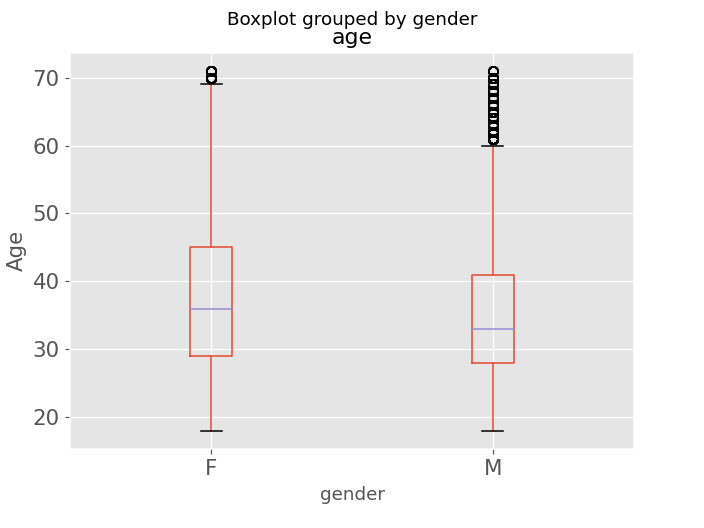

In [83]:
init_data.boxplot(by='gender', column='age')

plt.ylabel('Age', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

На первый взгляд, может показаться, что средний возраст кредитующихся женщин выше, чем у мужчин. Давайте проверим данную гипотезу методом бутстрапа.

#### Проверка статистической значимости различий в среднем возрасте кредитуемых гендеров

In [154]:
def permutation_test(x:np.array, n_group_1:int, n_group_2:int) -> float:
    """
    Функция возвращает разность средних значений массивов первой и второй групп, которые были получены рандомным разделением 
    исходных индексов массива путем извлечения без возврата.
    
    x - исходный массив с результатами, полученный слиянием массивов результатов для двух разных групп (А, В)
    n_group_1 - длина массива записей наблюдений для группы А
    n_group_2 - длина массива записей наблюдений для группы В
    """
    total_result_len = n_group_1 + n_group_2
    index_group_1 = set(random.sample(range(total_result_len), n_group_1))
    index_group_2 = set(range(total_result_len)) - index_group_1
    return x.loc[index_group_1].mean() - x.loc[index_group_2].mean()

In [177]:
def bootstrap_feature(feature, grouping_feature, data, grouped_data=None, perm_test_number=5000):
    """
    Производит перестановочный тест параметра *feature* двух категорий, находящихся в столбце *grouping_feature*,
    по которым произведена группировка *grouped_data*. 
    Производит сравнение наблюдаемой в датасете разницы средних с бутстраповским распределением, расчитывает p-value,
    строит график бутстраповского распределения разностей средних.
    
    Параметры
    ----------
    feature : str
        Параметр для которого требуется определить статистическую значимость различия средних в двух категориях
        
    grouping_feature : str
        Название столбца в *data*, в котором находится информация о двух категориях, по которым идет сравнение
        
    data : pd.DataFrame
        Исходный массив данных
        
    grouped_data : pd.DataFrame, default: None
        Данные, сгруппированные по признаку *grouping_feature* 
        
    perm_test_number : int, default: 5000
        Количество перестановочных тестов
    
    Возвращает:
    ----------
    Словарь основных расчетных параметров и графика  со следующими ключами:
    
    'pvalue': float
        p-value, рассчитанное на основании перестановочного теста
        
    'graph': matplotlib.figure.Figure
        График бутстраповского распределения и наблюдаемого по данным значения
        
    'observed_diff': : float
        Разница средних в двух категориях
        
    'perm_diffs': pandas.Series
        Массив рассчитанных бутстрапированных разниц средних в двух категориях
        в формате pandas.Series   
    """
    cols = ['age', 'credit_count', 'credit_month',
            'credit_sum', 'monthly_income',
            'overdue_credit_count', 'score_shk']
    
    units = ['years', 'quantity', 'quantity',
             'roubles', 'roubles', 'quantity',
             'difference']
    
    xlabel_names = dict(zip(cols, units)) 
    
    if grouped_data is None:
        grouped_data = data.pivot_table(index=grouping_feature)
    
    g1, g2 = grouped_data.index
    observed_diff = grouped_data.loc[g1, feature] - gender_grouped.loc[g2, feature]
    print(f'Наблюдаемое различие между категориями {g1} и {g2} равно {observed_diff:.3f}')
    
    g1_observations = data[data[grouping_feature] == g1][feature].dropna().shape[0]
    g2_observations = data[data[grouping_feature] == g2][feature].dropna().shape[0]
    total_observations = data[feature].dropna().reset_index(drop=True)

    assert g1_observations + g2_observations == total_observations.shape[0], 'Длины массивов не совпадают'

    perm_diffs = pd.Series([permutation_test(total_observations, g1_observations, g2_observations)
                  for _ in tqdm(range(perm_test_number))])
    
    fig, ax = plt.subplots(figsize = (8,5))
    ax.hist(perm_diffs, bins=50)
    ax.axvline(observed_diff, color='black')
    ax.text(observed_diff, np.cbrt(perm_test_number), 'Observed\nvalue')
    ax.set_xlabel(xlabel_names[feature])
    ax.set_ylabel('Frequency')
    ax.set_title(f'Bootstrapped difference in mean {feature} for {g1} and {g2}')
    
    p_val_perm = min((perm_diffs < observed_diff).mean(), (perm_diffs > observed_diff).mean())
    print(f'Вероятность обнаружить результаты, обусловленные случайностью и превосходящие \
полученные данные, равна {p_val_perm*100:.5f} %.')
    
    return {'pvalue': p_val_perm,
            'graph': fig,
            'observed_diff': observed_diff,
            'perm_diffs': perm_diffs}

Наблюдаемое различие между категориями F и M равно 0.053


  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


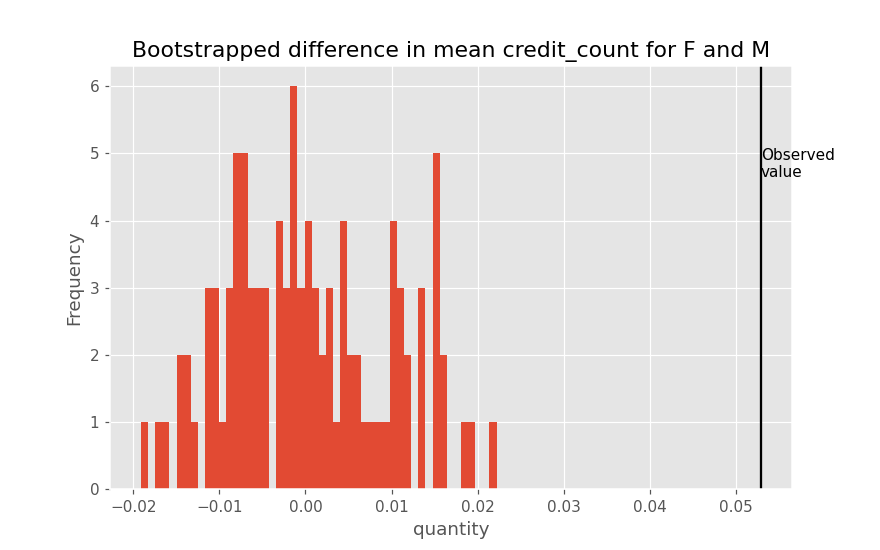

Вероятность обнаружить результаты, обусловленные случайностью и превосходящие полученные данные, равна 0.00000 %.


In [164]:
age_bootstrap_info = bootstrap_feature('age', 'gender', perm_test_number=2000)

Поскольку *-2,65 лет* не принадлежит бутстрапированной выборке, следовательно, ***нет оснований отвергать гипотезу*** о превосходящем среднем возрасте кредитующихся женщин.

#### Проверка статистической значимости различий количества кредитов от гендера

In [136]:
print(gender_grouped['credit_count'])

gender
F    2.132642
M    2.079737
Name: credit_count, dtype: float64


<IPython.core.display.Javascript object>


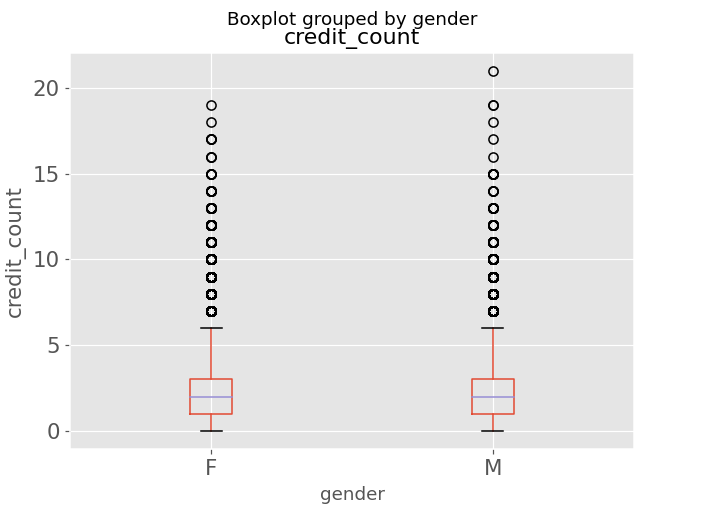

(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [130]:
init_data.boxplot(by='gender', column='credit_count')

plt.ylabel('credit_count', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

<IPython.core.display.Javascript object>


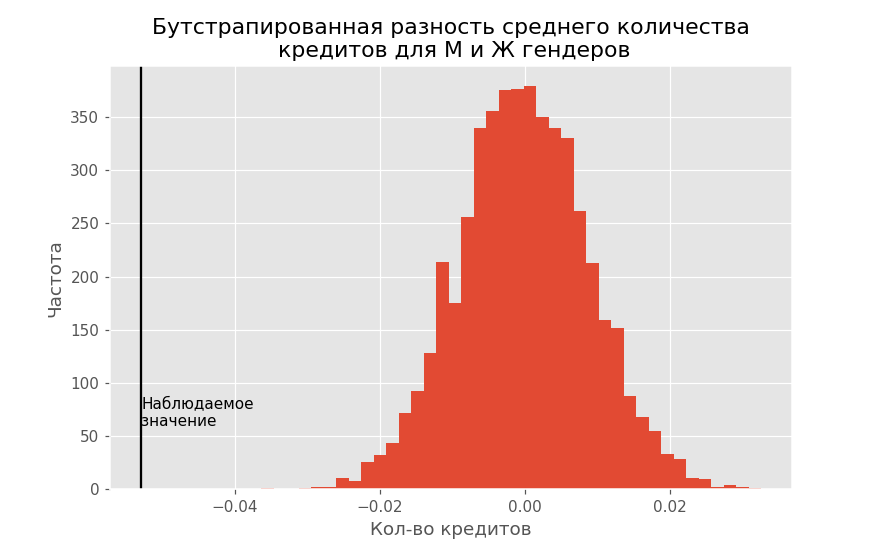

Text(0.5, 1.0, 'Бутстрапированная разность среднего количества\n кредитов для М и Ж гендеров')

In [140]:
credit_count_bootstrap_info = bootstrap_feature('credit_count', 'gender', perm_test_number=2000)

Поскольку наблюдаемое значение разностей среднего количества кредитов не принадлежит бутстрапированной выборке, следовательно, ***нет оснований отвергать гипотезу*** о превосходящем среднем количестве кредитов у кредитующихся женщин.

In [143]:
gender_grouped

,age,credit_count,credit_month,credit_sum,monthly_income,overdue_credit_count,score_shk
gender,,,,,,,
F,37.770404,2.132642,10.974419,25563.397526,35266.089623,0.045822,0.470975
M,35.120978,2.079737,10.987593,26669.878945,45405.846551,0.046340,0.467850


**Итого:** Средний возраст кредитующихся женщин выше, чем у мужчин, однако, и среднее количество кредитов у женщин также превосходит данный показатель для мужской части населения.

In [142]:
init_data['open_account_flg'].value_counts()

0    140690
1     30056
Name: open_account_flg, dtype: int64

### Гипотеза 2

Гипотеза заключается в наличии существенной разницы в количестве кредитов